In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
from tqdm import tqdm
import pysensors as ps
import pandas as pd
import time


In [5]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
#this part of the code is taken from multiple RE analysis
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)


In [6]:
# variable definition
subsample_x, subsample_y = 10, 10
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6# domain size in D units

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

Grid: 1600x2000, Subsampled: 160x200


In [7]:
# Data loading
# Since I work with only one tensor, I don't need dicts
tensor = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")


100%|██████████| 200/200 [00:07<00:00, 27.21it/s]

(200, 160, 8, 200)
Data loading complete!


In [8]:
def scale_and_center_tensor(tensor, component_names = component_names, log_scale=True, 
                             std_scale=True, epsilon=1e-12):
    tensor_scaled = tensor.copy()  
    for c_idx, comp_name in enumerate(component_names):
        component_data = tensor_scaled[:, :, c_idx, :].copy()            
        if log_scale:
            component_data = np.log10(np.maximum(component_data, epsilon))
        if std_scale:
            mean_val = component_data.mean()
            std_val = component_data.std()                
            if std_val < epsilon:
                std_val = epsilon  # Prevent divide-by-zero
            component_data = (component_data - mean_val) / std_val
        tensor_scaled[:, :, c_idx, :] = component_data
    return tensor_scaled

tensor_scaled = scale_and_center_tensor(tensor)

# Low Cost HOSVD

In [9]:
def subsampled_hosvd(tensor, sampling_ratio=0.3):
    n_modes = len(tensor.shape)
    factors = []
    start_time = time.time()
    for mode in range(n_modes):
        unfolded = tl.unfold(tensor, mode)
        m, n = unfolded.shape
        n_samples = int(n * sampling_ratio)
        n_samples = min(n_samples, n)
        sample_indices = np.random.choice(n, size=n_samples, replace=False)
        sampled_matrix = unfolded[:, sample_indices]
        U, _, _ = np.linalg.svd(sampled_matrix, full_matrices=False)
        n_components = min(m, n_samples)
        U_truncated = U[:, :n_components]
        factors.append(U_truncated)
    core = multi_mode_dot(tensor, [U.T for U in factors], modes=list(range(n_modes)))
    elapsed_time = time.time() - start_time
    return factors, core, elapsed_time

factors_sub, core_sub, time_sub = subsampled_hosvd(tensor_scaled, sampling_ratio=0.3)
print(f"Subsampled HOSVD completed in {time_sub:.4f} seconds")
print(f"Core shape: {core_sub.shape}")

Subsampled HOSVD completed in 5.0742 seconds
Core shape: (200, 160, 8, 200)


In [19]:
import numpy as np
import time
#-------------------------------------------------------------------------------------------------------------------------
def subsampler(data, subsampling_rates : list):
    """
    inputs:
        data: [x, y, t]
        subsampling_rates = [sample_rate_x, sample_rate_y]
    code:
        slices = tuple(slice(None, None, rate) for rate in subsampling_rates) + (slice(None),)
        return data[slices]
    """
    slices = tuple(slice(None, None, rate) for rate in subsampling_rates) + (slice(None),)
    return data[slices]
#-------------------------------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------
def important_idx_finder(array, energy_lvl):
    """
    inputs:
        array: 1-d array
        energy_lvl: scalar
    code:
        cumulative_energy = np.cumsum(array**2) / np.sum(array**2)
        return np.searchsorted(cumulative_energy, energy_lvl) + 1
    """
    cumulative_energy = np.cumsum(array**2) / np.sum(array**2)
    return np.searchsorted(cumulative_energy, energy_lvl) + 1
#--------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------
def lcSVD(reduced_matrix, Matrix, energy_lvl, t = False):
    if t:
        start = time.time()
        Ured, Sigma_values_red, VredT = np.linalg.svd(reduced_matrix, full_matrices=False)
        Sigma_matrix_red = np.diag(Sigma_values_red)
        important_modes_idx = important_idx_finder(Sigma_values_red, energy_lvl)

        Ured = Ured[:, :important_modes_idx]
        Vred = VredT.T[:, :important_modes_idx]  
        Q_Ured, R_Ured = np.linalg.qr(Ured)
        Ured_scaled = Q_Ured ##since U is orthogonal by construction of doing inverse you can compute it like this

        Q_Vred, R_Vred = np.linalg.qr(Vred)
        Vred_scaled = Q_Vred #since V is orthogonal by construction, instead of doing inverse you can compute it like this
        ss = Ured_scaled.T @ reduced_matrix @ Vred_scaled
        ss1 = np.sign(np.diag(np.diag(ss)))
        Vred_scaled = Vred_scaled @ ss1
        Sigma_matrix_red = Sigma_matrix_red[:important_modes_idx, :important_modes_idx]
        U = Matrix @ Vred_scaled @ np.linalg.inv(Sigma_matrix_red)
        end = time.time()
        return U, Sigma_matrix_red, Vred_scaled, end-start
    else:
        Ured, Sigma_values_red, VredT = np.linalg.svd(reduced_matrix, full_matrices=False)
        Sigma_matrix_red = np.diag(Sigma_values_red)
        important_modes_idx = important_idx_finder(Sigma_values_red, energy_lvl)

        Ured = Ured[:, :important_modes_idx]
        Vred = VredT.T[:, :important_modes_idx]  
        Q_Ured, R_Ured = np.linalg.qr(Ured)
        Ured_scaled = Q_Ured ##since U is orthogonal by construction of doing inverse you can compute it like this

        Q_Vred, R_Vred = np.linalg.qr(Vred)
        Vred_scaled = Q_Vred #since V is orthogonal by construction, instead of doing inverse you can compute it like this
        ss = Ured_scaled.T @ reduced_matrix @ Vred_scaled
        ss1 = np.sign(np.diag(np.diag(ss)))
        Vred_scaled = Vred_scaled @ ss1
        Sigma_matrix_red = Sigma_matrix_red[:important_modes_idx, :important_modes_idx]
        U = Matrix @ Vred_scaled @ np.linalg.inv(Sigma_matrix_red)
        print("Matrix:", Matrix.shape)
        print("Vred_scaled:", Vred_scaled.shape)
        print("Sigma:", Sigma_matrix_red.shape)
        return U, Sigma_matrix_red, Vred_scaled
#--------------------------------------------------------------------------------------------------

In [23]:
n_modes = len(tensor.shape)
factors = []
start_time = time.time()
subsampled_tensor = tensor[::2, ::2, ...]
chem_sub_unfold, chem_unfold = tl.unfold(subsampled_tensor, mode = 2), tl.unfold(tensor, mode=2)
U_chem, S_chem, V_chem = lcSVD(chem_sub_unfold, chem_unfold, energy_lvl=1e-2)
Ux , Sx, Vx = np.linalg.svd(tl.unfold(tensor, mode=0), full_matrices=False)
Uy , Sy, Vy = np.linalg.svd(tl.unfold(tensor, mode=1),  full_matrices=False) 


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1600000 is different from 6400000)

In [ ]:
def low_cost(tensor, subsample_x= 2, subsample_y =2):
    n_modes = len(tensor.shape)
    factors = []
    start_time = time.time()
    
    for mode in range(2):
        if mode == 0:
            sub_tensor = tensor[::subsample_y, ...]
        else:
            sub_tensor = tensor[:, ::subsample_x, ...]
        
        unfolded = tl.unfold(sub_tensor, mode)
        unfolded_original = tl.unfold(tensor, mode)
        m, n = unfolded.shape
        
        _ , s, V = np.linalg.svd(unfolded, full_matrices=False)
        print(unfolded_original.shape)
        print(V.T.shape)
        U = unfolded_original @ V.T @ np.diag(1/s) 
        n_components = len(s)
        
        factors.append(U)
               
    elapsed_time = time.time() - start_time
    for mode in range(2, n_modes):
        unfolded = tl.unfold(tensor, mode)
        U, s, _ = np.linalg.svd(unfolded, full_matrices=False)
        n_components = len(s)
        factors.append(U[:, :n_components])
    
    core = multi_mode_dot(tensor, [U.T for U in factors], modes=list(range(n_modes)))
    
    elapsed_time = time.time() - start_time
    
    return factors, core, elapsed_time, 
factors_sensor, core_sensor, time_sensor, sensors = low_cost(tensor_scaled)
print(f"Sensor-based HOSVD completed in {time_sensor:.4f} seconds")
print(f"Core shape: {core_sensor.shape}")
print(f"Number of sensors selected per mode: {[(k, len(v)) for k, v in sensors.items()]}")

(200, 256000)
(256000, 100)
(160, 320000)
(320000, 80)


ValueError: not enough values to unpack (expected 4, got 3)

RECONSTRUCTION ERROR COMPARISON

Subsampled HOSVD:
  Absolute Error: 0.000000
  Relative Error: 0.000000 (0.0000%)
  Computation Time: 5.3646 seconds

Sensor-based HOSVD:
  Absolute Error: 213833393644228.437500
  Relative Error: 29884125253.007450 (2988412525300.7451%)
  Computation Time: 14.4063 seconds

Error Ratio (Sensor/Subsampled): 13993908571723268381212672.0000
Time Ratio (Sensor/Subsampled): 2.6854


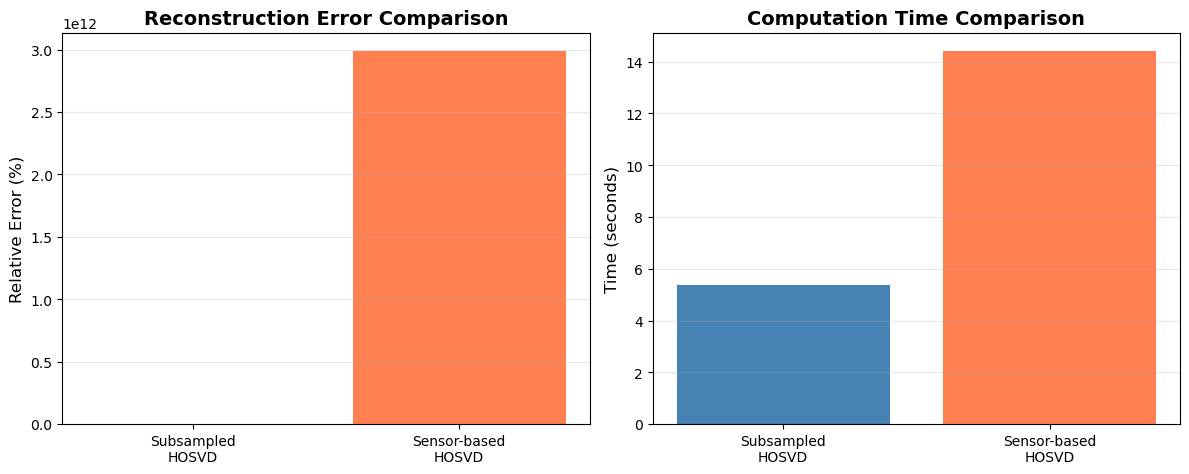

In [ ]:
# Reconstruction Error Comparison
print("=" * 60)
print("RECONSTRUCTION ERROR COMPARISON")
print("=" * 60)

# Reconstruct tensors from both methods
tensor_reconstructed_sub = multi_mode_dot(core_sub, factors_sub, modes=list(range(len(tensor_scaled.shape))))
tensor_reconstructed_sensor = multi_mode_dot(core_sensor, factors_sensor, modes=list(range(len(tensor_scaled.shape))))

# Calculate Frobenius norm errors
frobenius_original = np.linalg.norm(tensor_scaled)
error_sub = np.linalg.norm(tensor_scaled - tensor_reconstructed_sub)
error_sensor = np.linalg.norm(tensor_scaled - tensor_reconstructed_sensor)

# Calculate relative errors
relative_error_sub = error_sub / frobenius_original
relative_error_sensor = error_sensor / frobenius_original

print(f"\nSubsampled HOSVD:")
print(f"  Absolute Error: {error_sub:.6f}")
print(f"  Relative Error: {relative_error_sub:.6f} ({relative_error_sub*100:.4f}%)")
print(f"  Computation Time: {time_sub:.4f} seconds")

print(f"\nSensor-based HOSVD:")
print(f"  Absolute Error: {error_sensor:.6f}")
print(f"  Relative Error: {relative_error_sensor:.6f} ({relative_error_sensor*100:.4f}%)")
print(f"  Computation Time: {time_sensor:.4f} seconds")

print(f"\nError Ratio (Sensor/Subsampled): {relative_error_sensor/relative_error_sub:.4f}")
print(f"Time Ratio (Sensor/Subsampled): {time_sensor/time_sub:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

methods = ['Subsampled\nHOSVD', 'Sensor-based\nHOSVD']
errors = [relative_error_sub * 100, relative_error_sensor * 100]
times = [time_sub, time_sensor]

axes[0].bar(methods, errors, color=['steelblue', 'coral'])
axes[0].set_ylabel('Relative Error (%)', fontsize=12)
axes[0].set_title('Reconstruction Error Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(methods, times, color=['steelblue', 'coral'])
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)